# Feature Extract

Usage: function plotting will plot rmsd, rmsd histogram, rmsf and PCA projection

In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
#XRD Ensemble
#28 4NPQ
#18 4HFI

In [2]:
residue_selection = 'resSeq 8 to 316'

In [3]:
location = '/media/scottzhuang/data/MD/'

In [4]:
traj_notes = ['5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3','5NJY_F238L_pH70_md1',
                 '5NJY_F238L_pH70_md2','5NJY_F238L_pH70_md3','5NJY_I233T_pH70_md4',
                  '5NJY_I233T_pH70_md2','5NJY_I233T_pH70_md3','5NJY_F238LI233T_pH70_md1',
                  '5NJY_F238LI233T_pH70_md2','5NJY_F238LI233T_pH70_md3','5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3','5NJY_F238L_pH46_md1',
                 '5NJY_F238L_pH46_md2','5NJY_F238L_pH46_md3','5NJY_I233T_pH46_md1',
                  '5NJY_I233T_pH46_md2','5NJY_I233T_pH46_md3','5NJY_F238LI233T_pH46_md1',
                  '5NJY_F238LI233T_pH46_md2','5NJY_F238LI233T_pH46_md3','4HFI_pH46_md1','4HFI_pH46_md2','4HFI_pH46_md3','4HFI_F238L_pH46_md1',
                 '4HFI_F238L_pH46_md2','4HFI_F238L_pH46_md3','4HFI_I233T_pH46_md1',
                  '4HFI_I233T_pH46_md2','4HFI_I233T_pH46_md3','4HFI_F238LI233T_pH46_md1',
                  '4HFI_F238LI233T_pH46_md2','4HFI_F238LI233T_pH46_md3','4NPQ_pH70_md5','4NPQ_pH70_md6','4NPQ_pH70_md7','4NPQ_F238L_pH70_md3',
                 '4NPQ_F238L_pH70_md4','4NPQ_F238L_pH70_md5','4NPQ_I233T_pH70_md3',
                  '4NPQ_I233T_pH70_md4','4NPQ_I233T_pH70_md5','4NPQ_F238LI233T_pH70_md3',
                  '4NPQ_F238LI233T_pH70_md4','4NPQ_F238LI233T_pH70_md5']

In [5]:
def create_md_dataframe():    
    md_data = pd.DataFrame(columns=list(['MD_name','pH','replicate','traj_time']))
    return md_data

In [6]:
def create_metadata(md_data= None):   
    def append_metadata(traj_note,location = '/media/scottzhuang/data/MD/',skip=10,md_data= md_data):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        if skip == 1:
            traj = md.load(location + traj_location,top= location + top_location,stride=10)
        else:
            traj = md.load(location + traj_location,top= location + top_location)
        print("In " + traj_note + ", simulation runs " + str(10 * traj.n_frames) + " ns.")
        md_name = traj_note[:traj_note.find('pH')-1]
        pH = traj_note[traj_note.find('pH')+2:traj_note.find('pH')+4]
        md_replicate = traj_note[-1]
        for i in range(0,traj.n_frames):
            md_data.loc[md_data.shape[0]+1] = [md_name,pH,md_replicate,i]

    for traj_note in traj_notes:
        append_metadata(traj_note)

In [7]:
def create_system_notation(md_data = None):
    system_notation = 0
    notation = -1
    location = '/media/scottzhuang/data/MD/'
    skip=10
    notations = []
    increment = 0
    for traj_note in traj_notes:
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if traj_note.find('md1') >= 0:
            notation = notation + 1
        if traj_note == '5NJY_I233T_pH70_md4' or traj_note == '4NPQ_pH70_md5' or  traj_note == '4NPQ_F238L_pH70_md3' or traj_note == '4NPQ_I233T_pH70_md3' or traj_note == '4NPQ_F238LI233T_pH70_md3':
            notation = notation + 1

        for frame in range(0,traj.n_frames):
            notations.append(notation)
        #if increment % 3 == 2:
        #    notation = notation + 1
        #increment = increment + 1 
        
    md_data['system'] = notations

In [8]:
def create_rmsd_data(md_data= None):
    def append_rmsd_data(traj_note,location = '/media/scottzhuang/data/MD/',ref_name = None, skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if ref_name != None:
            ref_location = ("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/" + ref_name + ".pdb")
        else:
            ref_location = location + top_location
        ref_traj = md.load(ref_location)
        topology = traj.topology
        if traj.n_atoms != ref_traj.n_atoms:
            traj = traj.atom_slice(topology.select(residue_selection))
        traj.superpose(ref_traj,0)
        rmsd_data.extend(list(md.rmsd(traj, ref_traj)*10))
    rmsd_data = []
    for traj_note in traj_notes:
        append_rmsd_data(traj_note)
    md_data['rmsd']= rmsd_data

In [9]:
def create_cppca_data(md_data = None,residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
    def combined_ppca_reduced_cartesian(residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
        wholetraj = md.load("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/new_ensemble.pdb")
        wholetraj.superpose(wholetraj,28)
        topology = wholetraj.topology
        wholetraj_sliced_ecd = wholetraj.atom_slice(topology.select(residue_selection_1))
        wholetraj_sliced_ecd.superpose(wholetraj_sliced_ecd,28)
        wholetraj_sliced_tmd = wholetraj.atom_slice(topology.select(residue_selection_2))
        wholetraj_sliced_tmd.superpose(wholetraj_sliced_tmd,28)
        ppca_ecd = PCA(n_components=1)
        ppca_tmd = PCA(n_components=1)
        partial_reduced_cartesian = [ppca_ecd.fit_transform(wholetraj_sliced_ecd.xyz.reshape(wholetraj_sliced_ecd.n_frames, wholetraj_sliced_ecd.n_atoms * 3)), ppca_tmd.fit_transform(wholetraj_sliced_tmd.xyz.reshape(wholetraj_sliced_tmd.n_frames, wholetraj_sliced_tmd.n_atoms * 3))]    
        return partial_reduced_cartesian, wholetraj_sliced_ecd, wholetraj_sliced_tmd,ppca_ecd,ppca_tmd
    
    def append_projection_on_combined_ppca_data(traj_note, location = '/media/scottzhuang/data/MD/',skip = 10, residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        topology = traj.topology
        traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1))
        traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))

        traj_sliced_ecd.superpose(wholetraj_sliced_ecd,28)
        traj_sliced_tmd.superpose(wholetraj_sliced_tmd,28)

        reduced_cartesian_ecd.extend(ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3)).T[0])
        reduced_cartesian_tmd.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[0])
    partial_reduced_cartesian, wholetraj_sliced_ecd,wholetraj_sliced_tmd, ppca_ecd,ppca_tmd = combined_ppca_reduced_cartesian(residue_selection_1,residue_selection_2)
    reduced_cartesian_ecd = []
    reduced_cartesian_tmd = []
    for traj_note in traj_notes:
        append_projection_on_combined_ppca_data(traj_note)
    md_data['ecd_pc1']= reduced_cartesian_ecd
    md_data['tmd_pc1']= reduced_cartesian_tmd

In [10]:
def create_cppca_data_2(md_data = None,residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
    def combined_ppca_reduced_cartesian(residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
        wholetraj = md.load("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/new_ensemble.pdb")
        wholetraj.superpose(wholetraj,28)
        topology = wholetraj.topology
        wholetraj_sliced_ecd = wholetraj.atom_slice(topology.select(residue_selection_1))
        wholetraj_sliced_ecd.superpose(wholetraj_sliced_ecd,28)
        wholetraj_sliced_tmd = wholetraj.atom_slice(topology.select(residue_selection_2))
        wholetraj_sliced_tmd.superpose(wholetraj_sliced_tmd,28)
        ppca_ecd = PCA(n_components=2)
        ppca_tmd = PCA(n_components=2)
        partial_reduced_cartesian = [ppca_ecd.fit_transform(wholetraj_sliced_ecd.xyz.reshape(wholetraj_sliced_ecd.n_frames, wholetraj_sliced_ecd.n_atoms * 3)), ppca_tmd.fit_transform(wholetraj_sliced_tmd.xyz.reshape(wholetraj_sliced_tmd.n_frames, wholetraj_sliced_tmd.n_atoms * 3))]    
        return partial_reduced_cartesian, wholetraj_sliced_ecd, wholetraj_sliced_tmd,ppca_ecd,ppca_tmd
    
    def append_projection_on_combined_ppca_data(traj_note, location = '/media/scottzhuang/data/MD/',skip = 10, residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        topology = traj.topology
        traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1))
        traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))

        traj_sliced_ecd.superpose(wholetraj_sliced_ecd,28)
        traj_sliced_tmd.superpose(wholetraj_sliced_tmd,28)

        reduced_cartesian_ecd.extend(ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3)).T[1])
        reduced_cartesian_tmd.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[1])
    partial_reduced_cartesian, wholetraj_sliced_ecd,wholetraj_sliced_tmd, ppca_ecd,ppca_tmd = combined_ppca_reduced_cartesian(residue_selection_1,residue_selection_2)
    reduced_cartesian_ecd = []
    reduced_cartesian_tmd = []
    for traj_note in traj_notes:
        append_projection_on_combined_ppca_data(traj_note)
    md_data['ecd_pc2']= reduced_cartesian_ecd
    md_data['tmd_pc2']= reduced_cartesian_tmd

In [11]:
def create_pca_data(md_data = None):
    def ensemble_pca_cartesian():
        wholetraj = md.load("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/new_ensemble.pdb")
        wholetraj.superpose(wholetraj,28)
        pca = PCA(n_components=2)
        reduced_cartesian = pca.fit_transform(wholetraj.xyz.reshape(wholetraj.n_frames,wholetraj.n_atoms *3))
        return wholetraj, pca
    def append_pca_data(traj_note,location = '/media/scottzhuang/data/MD/',skip = 10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top =location + top_location)
        topology = traj.topology
        traj = traj.atom_slice(topology.select("resSeq 8 to 316"))
        traj.superpose(wholetraj,28)
        traj_reduced_cartesian = pca.transform(traj.xyz.reshape(traj.n_frames,traj.n_atoms * 3))
        pca1.extend(traj_reduced_cartesian.T[0])
        pca2.extend(traj_reduced_cartesian.T[1])
    pca1 = []
    pca2 = []
    wholetraj, pca = ensemble_pca_cartesian()
    for traj_note in traj_notes:
        append_pca_data(traj_note)
    md_data['wholepca_pc1'] = pca1
    md_data['wholepca_pc2'] = pca2

In [12]:
def create_domain_twist_data(md_data = None):
    def append_domain_twist(traj_note,location = '/media/scottzhuang/data/MD/',skip = 10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)        
        traj.superpose(traj,0)
        topology = traj.topology
        domain_twist = []
        for chain in range (0,5):
            residue_selection_1 = "resid " + str(8+chain*311) + " to " + str(192+chain*311)
            residue_selection_2 = "resid " + str(192+chain*311) + " to " + str(310+chain*311)
            traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1))
            traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))
            angle = []
            for i in range(0,traj.n_frames):
                cen_mass_ecd = md.compute_center_of_mass(traj_sliced_ecd[i])[0]
                cen_mass_tmd = md.compute_center_of_mass(traj_sliced_tmd[i])[0]
                cen_mass = md.compute_center_of_mass(traj[i])[0]
                cen_mass_ecd[2] = cen_mass[2]
                cen_mass_tmd[2] = cen_mass[2]
                vec_ecd = cen_mass_ecd - cen_mass
                vec_tmd = cen_mass_tmd - cen_mass
                veclength_ecd = np.sqrt(np.sum(np.power(vec_ecd,2)))
                veclength_tmd = np.sqrt(np.sum(np.power(vec_tmd,2)))
                angle.append(57.2958 * np.arccos(np.dot(vec_ecd,vec_tmd) /(veclength_ecd * veclength_tmd)))
            domain_twist.append(angle)
        domain_twist_data.extend(np.mean(np.asarray(domain_twist),axis=0))
    domain_twist_data = []
    for traj_note in traj_notes:
        domain_twist_avg = append_domain_twist(traj_note)
    md_data['domain twist']= domain_twist_data

In [13]:
def create_hole_data(md_data = None):
    import MDAnalysis as mda
    from MDAnalysis.analysis.hole import HOLEtraj
    def append_hole_data(traj_note,location = '/media/scottzhuang/data/MD/',skip = 10): 
        hole_traj_location = location + traj_note + '/' + traj_note + ".hole.traj.pdb"
        u = mda.Universe(hole_traj_location)
        H = HOLEtraj(u, executable="~/hole2/exe/hole")
        H.run()
        hole_data.extend(H.min_radius().T[1])
    hole_data = []
    for traj_note in traj_notes:
        append_hole_data(traj_note)
    md_data['min hole radius']=hole_data

In [14]:
def create_helix_tilt_data(md_data = None):
    def append_helix_tilt_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        tilt_data = pd.read_csv(location + traj_note + '/' + traj_note + '.tilt.csv',sep=" ")
        tilt_data.columns = ['traj_time','avg','ang1','ang2','ang3','ang4','ang5']
        helix_tilt_data.extend(tilt_data['avg'])
    helix_tilt_data = []
    for traj_note in traj_notes:
        append_helix_tilt_data(traj_note)
    md_data['helix tilt angle'] = helix_tilt_data

In [15]:
def create_helix_twist_data(md_data = None):
    def append_helix_twist_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        twist = pd.read_csv(location + traj_note + '/' + traj_note + '.twist.csv',sep=" ")
        twist.columns = ['traj_time','avg','ang1','ang2','ang3','ang4','ang5']
        helix_twist_data.extend(twist['avg'])
    helix_twist_data = []
    for traj_note in traj_notes:
        append_helix_twist_data(traj_note)
    md_data['helix twist angle'] = helix_twist_data

In [16]:
def create_pore_profile(md_data = None):
    def pore_rad(traj_note,location = '/media/scottzhuang/data/MD/'):
        top_location = traj_note + '/' + traj_note + ".protein.gro"
        traj_name = traj_note + '/' + traj_note +  ".skip10.protein.xtc"    
        traj = md.load(location + traj_name,top = location +top_location)
        ca_top_location = traj_note + '/' + traj_note +  ".ca.pdb"
        ca_traj_name = traj_note + '/' + traj_note +  ".skip10.ca.xtc"    
        ca_traj = md.load(location + ca_traj_name,top = location + ca_top_location)
        topology = traj.topology
        pore_profile = pd.DataFrame(columns=['traj_time','resid','pore_radius'])
        m = 0
        incre = 0
        for i in [217,221,225,228,232,235]:
            group_1 = np.arange(i,i + 1245, 311)
            xyz_inter = np.mean(ca_traj.xyz[:,group_1],axis=1)
            chain = topology.add_chain()
            residue = topology.add_residue('ALA',chain)
            topology.add_atom('H','H',residue)
            traj.topology = topology
            traj.xyz = np.append(traj.xyz,xyz_inter.reshape([traj.n_frames,1,3]),axis=1)
            pairs = list(itertools.product(group_1,[1555 + incre]))
            for j in range(0,traj.n_frames):
                pore_profile.loc[m] = [j,i,np.mean(md.compute_contacts(traj[j], pairs)[0])]
                m = m + 1
            incre = incre +1
        pore_data_222.extend(pore_profile[pore_profile['resid'] == 217]['pore_radius'])
        pore_data_226.extend(pore_profile[pore_profile['resid'] == 221]['pore_radius'])
        pore_data_230.extend(pore_profile[pore_profile['resid'] == 225]['pore_radius'])
        pore_data_233.extend(pore_profile[pore_profile['resid'] == 228]['pore_radius'])
        pore_data_237.extend(pore_profile[pore_profile['resid'] == 232]['pore_radius'])
        pore_data_240.extend(pore_profile[pore_profile['resid'] == 235]['pore_radius'])
    import itertools
    pore_data_222 = []
    pore_data_226 = []
    pore_data_230 = []
    pore_data_233 = []
    pore_data_237 = []
    pore_data_240 = []

    for traj_note in traj_notes:
        pore_rad(traj_note)
    md_data['pore_profile_222'] = pore_data_222
    md_data['pore_profile_226'] = pore_data_226
    md_data['pore_profile_230'] = pore_data_230
    md_data['pore_profile_233'] = pore_data_233
    md_data['pore_profile_237'] = pore_data_237
    md_data['pore_profile_240'] = pore_data_240

In [17]:
def create_hydration_profile(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 10 -10 resid 235) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data'] = hydration_data

In [18]:
def create_hydration_profile_2(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 3 -3 resid 235) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_235_3a'] = hydration_data

In [19]:
def create_hydration_profile_3(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 3 -3 resid 233) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_233_3a'] = hydration_data

In [20]:
def create_hydration_profile_4(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 3 -3 resid 238) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_238_3a'] = hydration_data

In [44]:
def create_hydration_profile_5(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 3 -3 resid 226) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_226_3a'] = hydration_data

In [46]:
def create_hydration_profile_7(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 3 -3 resid 240) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_240_3a'] = hydration_data

In [94]:
def create_hydration_profile_8(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cylayer 7 20 8 -8 resid 235) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_m123'] = hydration_data

In [229]:
def create_hydration_profile_9(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cylayer 7 20 8 -8 resid 235) and name OW and (around 15 resid 304)",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_intra'] = hydration_data

In [230]:
def create_hydration_profile_10(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cylayer 7 20 8 -8 resid 235) and name OW and not(around 15 resid 304)",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_inter'] = hydration_data

In [264]:
def create_beta_expansion(md_data = None):
    def append_beta_expansion_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        distance = []
        for chain in range(0,5):
            distance.append(md.compute_distances(traj,[[27 + chain * 311,187 + chain * 311]]))
        beta_expansion_data.extend(np.mean(distance,axis=0).T[0])
    beta_expansion_data = []
    for traj_note in traj_notes:
        append_beta_expansion_data(traj_note)
    md_data['beta_expansion'] = beta_expansion_data

In [48]:
def create_M2_radius(md_data = None):
    def append_M2_radius_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        M2_selection = 'resSeq 231 to 245'
        traj_M2 = traj.atom_slice(topology.select(M2_selection))
        M2_radius_data.extend(md.compute_rg(traj_M2).T) 
    M2_radius_data = []
    for traj_note in traj_notes:
        append_M2_radius_data(traj_note)
    md_data['M2_radius'] = M2_radius_data

In [49]:
def create_ECD_radius(md_data = None):
    def append_ECD_radius_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        ECD_selection = 'resSeq 5 to 194'
        traj_ECD = traj.atom_slice(topology.select(ECD_selection))
        ECD_radius_data.extend(md.compute_rg(traj_ECD).T) 
    ECD_radius_data = []
    for traj_note in traj_notes:
        append_ECD_radius_data(traj_note)
    md_data['ECD_radius'] = ECD_radius_data

In [50]:
def create_M2_M1_distance(md_data = None):
    def distance_calculate(x,y):
        dist = np.sqrt(np.power(x[0]-y[0],2) + np.power(x[1]-y[1],2) + np.power(x[2]-y[2],2))
        return dist
    def append_M2_M1_distance_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        distance = []
        for chain in range(0,4):
            M1_selection = 'resid ' + str(192 + chain * 311) + ' to ' + str(196 + chain * 311)
            M2_selection = 'resid ' + str(233 + (chain + 1) * 311) + ' to ' + str(238 + (chain + 1) * 311)
            traj_M1 = traj.atom_slice(topology.select(M1_selection))
            traj_M2 = traj.atom_slice(topology.select(M2_selection))
            distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))
        M1_selection = 'resid ' + str(192 + 4 * 311) + ' to ' + str(196 + 4 * 311)
        M2_selection = 'resid ' + str(233) + ' to ' + str(238)
        traj_M1 = traj.atom_slice(topology.select(M1_selection))
        traj_M2 = traj.atom_slice(topology.select(M2_selection))
        distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))
        #print((np.mean(np.asarray(distance),axis=0))
        M2_M1_distance.extend(np.mean(distance,axis=0))
    M2_M1_distance = []
    for traj_note in traj_notes:
        append_M2_M1_distance_data(traj_note)
    md_data['M2_M1_distance'] = M2_M1_distance
    #print(M2_M1_distance)

In [51]:
def create_M1_kink(md_data = None):
    def angle_calculate(x,y,z):
        angle_set = []
        for i in range(0,x.shape[0]):
            angle_set.append(180 - 57.29 * np.arccos(np.dot((x[i]-y[i]),(z[i]-y[i]))/(np.linalg.norm(x[i]-y[i]) * np.linalg.norm(z[i]-y[i]))))
        return angle_set
    def append_M1_kink_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        angle = []
        for chain in range(0,5):
            M1_selection_up = 'resid ' + str(192 + chain * 311) + ' to ' + str(196 + chain * 311)
            M1_selection_mid = 'resid ' + str(194 + chain * 311) + ' to ' + str(198 + chain * 311)
            M1_selection_down = 'resid ' + str(197 + chain * 311) + ' to ' + str(208 + chain * 311)

            M1_up = traj.atom_slice(topology.select(M1_selection_up))
            M1_mid = traj.atom_slice(topology.select(M1_selection_mid))
            M1_down = traj.atom_slice(topology.select(M1_selection_down))
            angle.append(angle_calculate(md.compute_center_of_mass(M1_up), md.compute_center_of_mass(M1_mid), md.compute_center_of_mass(M1_down)))
        M1_kink.extend(np.mean(angle,axis=0))
    M1_kink = []
    for traj_note in traj_notes:
        append_M1_kink_data(traj_note)
    md_data['M1_kink'] = M1_kink


In [211]:
def create_hbond_resid_data(md_data = None):
    def add_hbond_data(traj_note,hbond_resid_selection,location = '/media/scottzhuang/data/MD/',):
        hbond_data = pd.read_csv(location + traj_note + '/hbond.csv')
        for time in set(hbond_data['time'].tolist()):
            hbond_resid_data.append(len(hbond_data[(hbond_data['donor_resid'] == hbond_resid_selection[0]) & (hbond_data['acceptor_resid'] == hbond_resid_selection[1]) & (hbond_data['time'] == time)]))
    for hbond_resid_selection in zip((235,239,243),(259,200,200)):
        hbond_resid_data = []
        for traj_note in traj_notes:
            add_hbond_data(traj_note,hbond_resid_selection)
        md_data['hbond' + str(hbond_resid_selection)] = hbond_resid_data

In [247]:
def create_hbond_239_235_data(md_data = None):
    def add_hbond_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        hbond_data = pd.read_csv(location + traj_note + '/resid235_239_hbond.csv')
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        n_frames = md.load(location + traj_location,top = location + top_location).n_frames
        for time in range(0,n_frames*10000,10000):
            hbond_resid_data.append(len(hbond_data[(hbond_data['time'] == time)]))
    hbond_resid_data = []
    for traj_note in traj_notes:
        add_hbond_data(traj_note)
    md_data['hbond_235_239'] = hbond_resid_data

In [260]:
def create_hbond_239_235_data(md_data = None):
    def add_hbond_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        hbond_data = pd.read_csv(location + traj_note + '/resid235_239_hbond.csv')
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        n_frames = md.load(location + traj_location,top = location + top_location).n_frames
        for time in range(0,n_frames*10000,10000):
            hbond_resid_data.append(len(hbond_data[(hbond_data['time'] == time) & ((hbond_data['donor_atom'] == 'HD21') | (hbond_data['donor_atom'] == 'HD22'))]))
    hbond_resid_data = []
    for traj_note in traj_notes:
        add_hbond_data(traj_note)
    md_data['hbond_235_239_donor'] = hbond_resid_data

In [220]:
def create_hbond_resid_200_239_data(md_data = None):
    def add_hbond_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        hbond_data = pd.read_csv(location + traj_note + '/resid200_239_hbond.csv')
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        n_frames = md.load(location + traj_location,top = location + top_location).n_frames
        for time in range(0,n_frames*10000,10000):                        
            hbond_resid_data.append(len(hbond_data[hbond_data['time'] == time]))
    hbond_resid_data = []
    for traj_note in traj_notes:
        add_hbond_data(traj_note)
    md_data['hbond_200_239'] = hbond_resid_data

In [223]:
def create_hbond_resid_200_243_data(md_data = None):
    def add_hbond_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        hbond_data = pd.read_csv(location + traj_note + '/resid200_243_hbond.csv')
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        n_frames = md.load(location + traj_location,top = location + top_location).n_frames
        for time in range(0,n_frames*10000,10000):                        
            hbond_resid_data.append(len(hbond_data[hbond_data['time'] == time]))
    hbond_resid_data = []
    for traj_note in traj_notes:
        add_hbond_data(traj_note)
    md_data['hbond_200_243'] = hbond_resid_data

In [246]:
def create_Hbond_235_259(md_data = None):

    def append_Hbond_235_259_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".protein.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".protein.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        traj = traj.atom_slice(topology.select('resSeq 235 and name NE2 or resSeq 259 and name O'))

        distance = []
        for chain in [0,2,4,6,8]:
            distance.append(md.compute_contacts(traj,[[chain,chain+1]])[0].T)
        Hbond_235_259.extend(np.mean(distance,axis=0).T)
    Hbond_235_259 = []
    for traj_note in traj_notes:
        append_Hbond_235_259_data(traj_note)
    md_data['Hbond_235_259'] = np.asarray(Hbond_235_259).T[0]

In [37]:
def create_Hbond_200_239(md_data = None):

    def append_Hbond_200_239_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".protein.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".protein.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        traj = traj.atom_slice(topology.select('resSeq 239 or (resSeq 200 and name O)'))
        distance = []
        for chain in [0,2,4,6]:
            distance.append(md.compute_contacts(traj,[[chain,chain+3]])[0].T)
        distance.append(md.compute_contacts(traj,[[8,1]])[0].T)
        Hbond_200_239.extend(np.mean(distance,axis=0).T)
    Hbond_200_239 = []
    for traj_note in traj_notes:
        append_Hbond_200_239_data(traj_note)
    md_data['Hbond_200_239'] = np.asarray(Hbond_200_239).T[0]

In [40]:
def create_Hbond_200_243(md_data = None):

    def append_Hbond_200_243_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".protein.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".protein.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        traj = traj.atom_slice(topology.select('resSeq 243 or (resSeq 200 and name O)'))
        distance = []
        for chain in [0,2,4,6]:
            distance.append(md.compute_contacts(traj,[[chain,chain+3]])[0].T)
        distance.append(md.compute_contacts(traj,[[8,1]])[0].T)
        Hbond_200_243.extend(np.mean(distance,axis=0).T)
    Hbond_200_243 = []
    for traj_note in traj_notes:
        append_Hbond_200_243_data(traj_note)
    md_data['Hbond_200_243'] = np.asarray(Hbond_200_243).T[0]

In [203]:
def create_Hbond_water_200_239(md_data = None):
    def add_hbond_data(traj_note,location = '/media/scottzhuang/data/MD/'):
        hbond_data_200 = pd.read_csv(location + traj_note + '/resid200_water_hbond.csv')
        hbond_data_239 = pd.read_csv(location + traj_note + '/resid239_water_hbond.csv')
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        n_frames = md.load(location + traj_location,top = location + top_location).n_frames
        for time in range(0,n_frames*10000,10000):            
            hbond200_set = set(hbond_data_200[(hbond_data_200['donor_resid'] == 200) & (hbond_data_200['time'] == time)]['acceptor_resid']).union(set(hbond_data_200[(hbond_data_200['acceptor_resid'] == 200) & (hbond_data_200['time'] == time)]['donor_resid']))
            hbond239_set = set(hbond_data_239[(hbond_data_239['donor_resid'] == 239) & (hbond_data_239['time'] == time)]['acceptor_resid']).union(set(hbond_data_239[(hbond_data_239['acceptor_resid'] == 239) & (hbond_data_239['time'] == time)]['donor_resid']))
            hbond_resid_data.append(len(hbond200_set.intersection(hbond239_set)))
    hbond_resid_data = []
    for traj_note in traj_notes:
        add_hbond_data(traj_note)
    md_data['hbond_water_200_239'] = hbond_resid_data

In [209]:
def create_Hbond_water_200_243(md_data = None):
    def add_hbond_data(traj_note,location = '/media/scottzhuang/data/MD/'):
        hbond_data_200 = pd.read_csv(location + traj_note + '/resid200_water_hbond.csv')
        hbond_data_243 = pd.read_csv(location + traj_note + '/resid243_water_hbond.csv')
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        n_frames = md.load(location + traj_location,top = location + top_location).n_frames
        for time in range(0,n_frames*10000,10000):
            hbond200_set = set(hbond_data_200[(hbond_data_200['donor_resid'] == 200) & (hbond_data_200['time'] == time)]['acceptor_resid']).union(set(hbond_data_200[(hbond_data_200['acceptor_resid'] == 200) & (hbond_data_200['time'] == time)]['donor_resid']))
            hbond243_set = set(hbond_data_243[(hbond_data_243['donor_resid'] == 243) & (hbond_data_243['time'] == time)]['acceptor_resid']).union(set(hbond_data_243[(hbond_data_243['acceptor_resid'] == 243) & (hbond_data_243['time'] == time)]['donor_resid']))
            hbond_resid_data.append(len(hbond200_set.intersection(hbond243_set)))
    hbond_resid_data = []
    for traj_note in traj_notes:
        add_hbond_data(traj_note)
    md_data['hbond_water_200_243'] = hbond_resid_data

In [201]:
def create_water_bridge_200_243_data(md_data = None):
    def add_water_bridge_data(traj_note,location = '/media/scottzhuang/data/MD/',skip=10):
        water_bridge_dataframe = pd.read_csv(location + traj_note + '/resid200_243_water_bridge.csv')
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        n_frames = md.load(location + traj_location,top = location + top_location).n_frames
        for time in range(0,n_frames*10000,10000):
            water_bridge_data.append(len(water_bridge_dataframe[water_bridge_dataframe['time'] == time]))
    water_bridge_data = []
    for traj_note in traj_notes:
        add_water_bridge_data(traj_note)
    md_data['water_bridge_200_243'] = water_bridge_data

In [202]:
def create_water_bridge_200_239_data(md_data = None):
    def add_water_bridge_data(traj_note,location = '/media/scottzhuang/data/MD/',skip=10):
        water_bridge_dataframe = pd.read_csv(location + traj_note + '/resid200_239_water_bridge.csv')
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        n_frames = md.load(location + traj_location,top = location + top_location).n_frames
        for time in range(0,n_frames*10000,10000):
            water_bridge_data.append(len(water_bridge_dataframe[water_bridge_dataframe['time'] == time]))
    water_bridge_data = []
    for traj_note in traj_notes:
        add_water_bridge_data(traj_note)
    md_data['water_bridge_200_239'] = water_bridge_data

In [205]:
create_water_bridge_200_243_data(md_data)

In [206]:
create_water_bridge_200_239_data(md_data)

In [207]:
create_Hbond_water_200_239(md_data)

In [208]:
create_Hbond_water_200_243(md_data)

In [25]:
def create_cluster_data(md_data = None):
    cluster_index = []
    def add_cluster_data(traj_note,location = '/media/scottzhuang/data/MD/',skip=10):
        cluster_data = pd.read_pickle(location + traj_note + '/ward_cluster_labels.pickle')
        cluster_index.extend(cluster_data)
    for traj_note in traj_notes:
        add_cluster_data(traj_note)
    md_data['cluster_index'] = cluster_index

In [35]:
create_cluster_data(md_data)

In [32]:
#md_data = create_md_dataframe()
#create_metadata(md_data= md_data)
md_data = pd.read_csv("glic_gating.csv")

In [36]:
md_data.to_csv("glic_gating.csv")

In [27]:
md_data

,Unnamed: 0,Unnamed: 0.1,MD_name,pH,replicate,traj_time,system,rmsd,wholepca_pc1,wholepca_pc2,...,"hbond(239, 200)","hbond(243, 200)",hbond_200_239,hbond_200_243,hydration_data_intra,hydration_data_inter,hbond_235_239,hbond_235_239_acceptor,hbond_235_239_donor,cluster_index
0,0,1,5NJY,70,1,0,0,0.000000,0.717673,3.350286,...,0,0,0,0,0,21,9,0,5,2
1,1,2,5NJY,70,1,1,0,1.727738,0.630747,4.148447,...,0,0,0,0,1,20,8,0,3,2
2,2,3,5NJY,70,1,2,0,2.020854,1.855654,3.210544,...,0,0,0,0,2,22,10,0,5,2
3,3,4,5NJY,70,1,3,0,1.915493,1.412526,3.407093,...,0,0,0,0,1,17,9,0,4,2
4,4,5,5NJY,70,1,4,0,1.899955,2.364887,3.248358,...,0,0,0,0,1,20,9,0,4,2
5,5,6,5NJY,70,1,5,0,2.043537,1.866259,2.947303,...,0,0,0,0,1,20,10,0,5,2
6,6,7,5NJY,70,1,6,0,1.885621,2.240279,2.618280,...,0,0,0,0,0,22,10,0,5,2
7,7,8,5NJY,70,1,7,0,1.995083,2.609149,2.053408,...,0,0,0,0,3,23,10,0,5,2
8,8,9,5NJY,70,1,8,0,2.042677,3.700861,2.066899,...,0,0,0,0,4,20,9,0,4,2
9,9,10,5NJY,70,1,9,0,2.152671,3.595904,2.555982,...,0,0,0,0,1,19,10,0,5,2


In [58]:
md_data = create_md_dataframe()
create_metadata(md_data= md_data)
create_system_notation(md_data = md_data)
create_rmsd_data(md_data= md_data)

In 5NJY_pH70_md1, simulation runs 1030 ns.
In 5NJY_pH70_md2, simulation runs 750 ns.
In 5NJY_pH70_md3, simulation runs 810 ns.
In 5NJY_F238L_pH70_md1, simulation runs 540 ns.
In 5NJY_F238L_pH70_md2, simulation runs 680 ns.
In 5NJY_F238L_pH70_md3, simulation runs 720 ns.
In 5NJY_I233T_pH70_md4, simulation runs 730 ns.
In 5NJY_I233T_pH70_md2, simulation runs 590 ns.
In 5NJY_I233T_pH70_md3, simulation runs 820 ns.
In 5NJY_F238LI233T_pH70_md1, simulation runs 830 ns.
In 5NJY_F238LI233T_pH70_md2, simulation runs 800 ns.
In 5NJY_F238LI233T_pH70_md3, simulation runs 880 ns.
In 5NJY_pH46_md1, simulation runs 780 ns.
In 5NJY_pH46_md2, simulation runs 1060 ns.
In 5NJY_pH46_md3, simulation runs 1030 ns.
In 5NJY_F238L_pH46_md1, simulation runs 930 ns.
In 5NJY_F238L_pH46_md2, simulation runs 950 ns.
In 5NJY_F238L_pH46_md3, simulation runs 1090 ns.
In 5NJY_I233T_pH46_md1, simulation runs 810 ns.
In 5NJY_I233T_pH46_md2, simulation runs 870 ns.
In 5NJY_I233T_pH46_md3, simulation runs 980 ns.
In 5NJY_F

In [ ]:
create_pca_data(md_data = md_data)
create_cppca_data(md_data= md_data)
create_domain_twist_data(md_data= md_data)
#create_hole_data(md_data= md_data)
create_cppca_data_2(md_data)
#create_hbond_data(md_data=md_data)
create_hydration_profile(md_data)
create_hydration_profile_2(md_data)
create_hydration_profile_3(md_data)
create_hydration_profile_4(md_data)
create_hydration_profile_5(md_data)
create_hydration_profile_7(md_data)
create_pore_profile(md_data)
create_helix_tilt_data(md_data)
create_helix_twist_data(md_data)
create_beta_expansion(md_data)
create_M2_radius(md_data)
create_ECD_radius(md_data)
create_M2_M1_distance(md_data)
create_M1_kink(md_data)

In [34]:
md_data.to_csv("glic_gating.csv")

In [268]:
md_data.columns

Index(['Unnamed: 0', 'MD_name', 'pH', 'replicate', 'traj_time', 'system',
       'rmsd', 'wholepca_pc1', 'wholepca_pc2', 'ecd_pc1', 'tmd_pc1',
       'domain twist', 'ecd_pc2', 'tmd_pc2', 'hydration_data',
       'hydration_data_235_3a', 'hydration_data_233_3a',
       'hydration_data_238_3a', 'hydration_data_226_3a',
       'hydration_data_240_3a', 'pore_profile_222', 'pore_profile_226',
       'pore_profile_230', 'pore_profile_233', 'pore_profile_237',
       'pore_profile_240', 'helix tilt angle', 'helix twist angle',
       'beta_expansion', 'M2_radius', 'ECD_radius', 'M2_M1_distance',
       'M1_kink', 'Hbond_235_259', 'Hbond_200_239', 'Hbond_200_243',
       'hydration_data_m123', 'hbond_water_200_239', 'hbond_water_200_243',
       'water_bridge_200_243', 'water_bridge_200_239', 'hbond(235, 259)',
       'hbond(239, 200)', 'hbond(243, 200)', 'hbond_200_239', 'hbond_200_243',
       'hydration_data_intra', 'hydration_data_inter', 'hbond_235_239',
       'hbond_235_239_acceptor', 

In [ ]:
md_data

In [78]:
traj_note = '4NPQ_pH70_md5'
skip=10
top_location = traj_note + '/' + traj_note + ".ca.gro"
traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
traj = md.load(location + traj_location,top= location + top_location)

In [79]:
distance,pairs = md.compute_contacts(traj)

In [80]:
contact_map = md.geometry.squareform(distance,pairs)

In [81]:
contact_map.shape

(84, 1555, 1555)

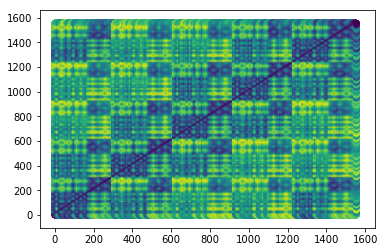

In [82]:
for i in range(0,1555):
    plt.scatter(np.zeros(1555) + i,np.arange(1555),c=contact_map[0][i])

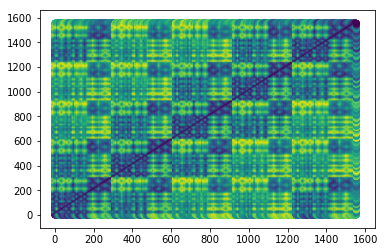

In [77]:
for i in range(0,1555):
    plt.scatter(np.zeros(1555) + i,np.arange(1555),c=contact_map[0][i])